In [1]:
from tracing.rl.a3cmodel import A3CModel
from tracing.rl.actions import *
from tracing.selenium_utils.controls import Types

from pretrain_dataset import *

import tensorflow as tf
import tensorflow_hub as hub

import threading
import json
import random
from scipy import misc
import numpy as np
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

In [2]:
dataset = '../../../resources/controls_popups_dataset.jsonl'
dataset_imgs_url = "https://drive.google.com/open?id=1whS0cYpJVIhbGRdRpjkWuyj2rFLW3iEQ"
download_dataset_imgs_if_need(dataset_imgs_url)

In [3]:
def split(arr, batch_size):
    batch = []
    for item in arr:
        if len(batch) >= batch_size:
            yield batch
            batch = []

        batch.append(item)

    if len(batch) > 0:
        yield batch
        
        
def read_img(ctrl, size = 300):
    img = misc.imread(ctrl['img_file'])
    img = (img - 128.)/128.
    shape = img.shape
    assert shape[0] == size or shape[1] == size, 'found image {}, control {}'.format(shape, ctrl)
    
    return img

In [4]:
class ControlPretrainModel:
    # If session is not defined than default session will be used
    def __init__(self, a3c_model, session, encoder):
        self.word_repr = None
        self.word_embeddings = None
                
        self.a3c_model = a3c_model
        self.session = session 
        self.encoder = encoder
        
        self.device = '/cpu:0'
        
        self.build_graph()
        
        
    def build_graph(self):
        self.text_labels = tf.placeholder(tf.float32, shape=[None, 512], name="text_labels")
        self.actions_labels = tf.placeholder(tf.float32, 
                                  shape=[None, self.a3c_model.num_actions - 1], name="possible_labels")
        self.text_loss = tf.losses.mean_squared_error(self.text_labels, self.a3c_model.text_pretrain)
        self.actions_loss = tf.nn.softmax_cross_entropy_with_logits_v2(
            labels = self.actions_labels, 
            logits = self.a3c_model.logits)
        
        self.actions_loss = tf.reduce_mean(self.actions_loss)
        
        self.lr = tf.placeholder_with_default(0.001, shape=(), name="lr")
        self.opt = tf.train.AdamOptimizer(self.lr)
        
        self.train_text_op = self.opt.minimize(self.text_loss)
        self.train_actions_op = self.opt.minimize(self.actions_loss)
        
        
    def read_imgs(self, batch):
        imgs = []
        
        for ctrl in batch:
            imgs.append(read_img(ctrl))
            
        return imgs
    
        
    def to_(self, batch):
        text_vectors = self.encoder.encode(batch)
        
    
    def get_text_input(self, batch, imgs, lr, l2, dropout = 0.8):
        text_vectors = self.encoder.encode(batch)
        return {
            self.a3c_model.img: imgs,
            self.text_labels: text_vectors,
            self.lr: lr,
            self.a3c_model.l2: l2,
            self.a3c_model.dropout: dropout
        }
    
    
    def get_actions_input(self, batch, imgs, lr, l2, dropout = 0.8):
        filtered_imgs = []
        actions = []
        for i, ctrl in enumerate(batch):
            pa = ctrl['possible_actions']
            if sum(pa) == 1:
                filtered_imgs.append(imgs[i])
                actions.append(pa)
        
        return {
            self.a3c_model.img: filtered_imgs,
            self.actions_labels: actions,
            self.lr: lr,
            self.a3c_model.l2: l2,
            self.a3c_model.dropout: dropout
        }
        
    
    def train(self, controls, epoch_start = 0, epoch_end = 5, 
              batch_size = 10, lr = 0.001, l2 = 0.001):
        
        for epoch in range(epoch_start, epoch_end):
            total = len(controls)
            random.shuffle(controls)
            
            print('epoch {} started, examples: {}'.format(epoch, total))
            sum_text_loss = 0
            sum_actions_loss = 0
            processed = 0
            batches = 0
            for batch in split(controls, batch_size):
                imgs = self.read_imgs(batch)
                text_feed = self.get_text_input(batch, imgs, lr, l2)
                _, text_loss = self.session.run([self.train_text_op, self.text_loss], 
                                                feed_dict = text_feed)
                
                actions_feed = self.get_actions_input(batch, imgs, lr, l2)
                _, actions_loss = self.session.run([self.train_actions_op, self.actions_loss], 
                                                   feed_dict = actions_feed)
                
                processed += len(batch)
                print ('Processed: {:2.2%}, text loss: {}, actions loss {}'
                       .format(processed/total, text_loss, actions_loss) , end="\r")
                
                sum_text_loss += text_loss
                sum_actions_loss += actions_loss
                batches += 1
            
            print('epoch ended')
            print('text loss: {}, actions loss: {}'
                  .format(sum_text_loss / batches, sum_actions_loss / batches))


In [5]:
class CachedEncoder:
    
    # Cache all controls
    def __init__(self, sentence_encoder, controls, session):
        self.sentence_encoder = sentence_encoder
        self.session = session
        
        self.cache = {}
        self.init_cache(controls)
        
    
    def get_text(self, source):
        if source is None:
            return None
        
        if isinstance(source, str):
            text = source
        elif 'label' not in source:
            return None
        else:
            text = source['label']
        
        if not text:
            return None

        text = text.strip()
        if not text:
            return None
        
        return text
    
    
    def init_cache(self, controls):

        texts = []
        
        for ctrl in controls:
            text = self.get_text(ctrl)
            if text:
                texts.append(text)
        
        texts = set(texts)
        print('Going to add to cadhe {} texts: '.format(len(texts)))
        
        input_sentences = tf.placeholder(tf.string, shape=[None])
        encode_op = self.sentence_encoder(input_sentences)

        for batch in split(texts, 20):
            embeddings = session.run(encode_op, feed_dict = {input_sentences: batch})
            for i, text in enumerate(batch):
                self.cache[text] = embeddings[i]
            
            del embeddings
        
        
    def encode(self, controls):
        result = []
        for ctrl in controls:
            text = self.get_text(ctrl)
            assert text is not None

            vec = self.cache.get(text)
            if vec is None:
                print('Not found vector for key: {}'.format(text))
                
            result.append(vec)
        
        return result

In [6]:
controls = []
with open(dataset) as f:
    for line in f:
        ctrl = json.loads(line)
        controls.append(ctrl)
        
to_train = [ctrl for ctrl in controls if ctrl['label'] and ctrl['label'].strip() != '']
print('controls: {} to train: {}'.format(len(controls), len(to_train)))

controls: 8275 to train: 6735


In [7]:
with tf.Session() as session:
    module_url = "https://tfhub.dev/google/universal-sentence-encoder/2"

    # Import the Universal Sentence Encoder's TF Hub module
    embed = hub.Module(module_url)
    
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    encoder = CachedEncoder(embed, to_train, session)

INFO:tensorflow:Using /home/aleksei/tf_hub_cache/ to cache modules.
Going to add to cadhe 2192 texts: 
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [8]:
def plot_similarity(labels, features, rotation):
    corr = np.inner(features, features)
    sns.set(font_scale=1.2)
    g = sns.heatmap(
        corr,
        xticklabels=labels,
        yticklabels=labels,
        vmin=0,
        vmax=1,
        cmap="YlOrRd")
    g.set_xticklabels(labels, rotation=rotation)
    g.set_title("Semantic Textual Similarity")


def run_and_plot(messages):
    message_embeddings = encoder.encode(messages)
    plot_similarity(messages, message_embeddings, 90)

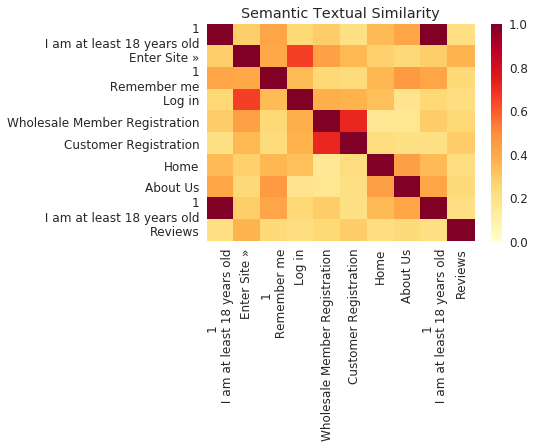

In [9]:
messages = [ctrl['label'] for ctrl in to_train[:10]]
run_and_plot(messages)

In [10]:
tf.reset_default_graph()
session = tf.Session()

In [11]:
a3c = A3CModel(len(Actions.actions), session = session, train_deep=True)
model = ControlPretrainModel(a3c, session, encoder)

session.run(tf.global_variables_initializer())
saver = tf.train.Saver()

In [12]:
for epoch in range(5):
    model.train(to_train, lr=0.001, 
            l2 = 0.001, 
            epoch_start = epoch, 
            epoch_end = epoch + 1, batch_size = 20)
    
    saver.save(session, './checkpoints/pretrain_checkpoint-{}'.format(epoch))

epoch 0 started, examples: 6735


/home/aleksei/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  from ipykernel import kernelapp as app


KeyboardInterrupt: 

In [13]:
saver.save(session, './checkpoints/pretrain_checkpoint-{}'.format(epoch))

'./checkpoints/pretrain_checkpoint-0'